In [18]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller #ADF 测试是一种检验时间序列数据是否具有单位根的方法，即判断数据是否具有随机漂移（非平稳性）的趋势。
import warnings
warnings.filterwarnings('ignore')

ADF（Augmented Dickey-Fuller）检验是一种用于检验时间序列数据是否具有单位根的检验方法。检验结果包括检验统计量ADF值、p值和若干阶数的不同置信水平的临界值。ADF值的取值范围通常是负无穷到正无穷，p值的取值范围是0到1之间。临界值的取值范围则取决于所选置信水平和数据样本的大小。通常，当ADF值小于临界值时，可以拒绝原假设（即数据具有单位根）；当p值小于置信水平时，也可以拒绝原假设。

In [19]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [20]:
def perform_adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [21]:
#get data
series = pd.read_csv('catfish.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series = series.asfreq(pd.infer_freq(series.index))
series = series.loc[datetime(2004,1,1):]
series = series.diff().diff().dropna()

In [22]:
series

Date
2004-03-01   -1067.0
2004-04-01   -4131.0
2004-05-01    3543.0
2004-06-01     401.0
2004-07-01    -405.0
               ...  
2012-08-01     353.0
2012-09-01   -2186.0
2012-10-01    1393.0
2012-11-01    -816.0
2012-12-01    -193.0
Freq: MS, Name: Total, Length: 106, dtype: float64

In [23]:
#check stationarity
perform_adf_test(series)

ADF Statistic: -7.162321
p-value: 0.000000


在ADF检验中，通常会设立一个显著性水平（significance level）$\alpha$，一般取0.01或0.05。如果得到的p值小于$\alpha$，则可以拒绝原假设，即拒绝存在单位根的假设，认为时间序列是平稳的；如果p值大于等于$\alpha$，则不能拒绝原假设，即无法拒绝时间序列存在单位根的假设，认为时间序列是非平稳的。
由于给出的p值为0.000000，小于通常的显著性水平0.01或0.05，因此可以拒绝原假设，认为该时间序列是平稳的。

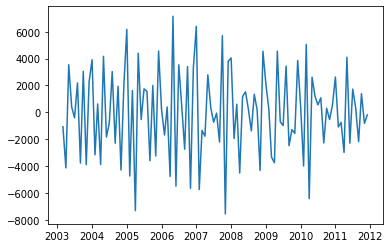

In [24]:
plt.plot(series)

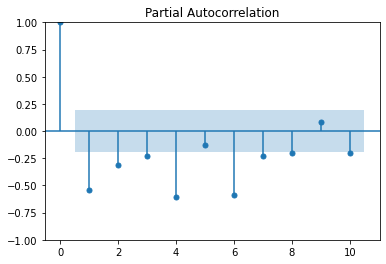

In [25]:
plot_pacf(series, lags=10)
plt.show()


# Either AR(1), AR(4), AR(6), or AR(10)

AR(p) 是指自回归模型，其中 p 表示使用前 p 个时间步的观测来预测当前时间步的观测。AR(p) 模型可以表示为： 


 X(t) = c + a(1)*X(t-1) + a(2)*X(t-2) + ... + a(p)*X(t-p) + e(t)
 其中，X(t) 是当前时间步的观测，X(t-1)、X(t-2)、...、X(t-p) 分别是前 p 个时间步的观测，a(1)、a(2)、...、a(p) 是自回归系数，c 是常数，e(t) 是白噪声。

In [26]:
plt.figure(figsize=(12,12))

ar_orders = [1, 4, 6, 10]
fitted_model_dict = {}

for idx, ar_order in enumerate(ar_orders):
    
    #create AR(p) model
    ar_model = ARIMA(series, order=(ar_order, 0, 0))
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
    plt.subplot(4,1,idx+1)
    plt.plot(series)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%ar_order, fontsize=16)

plt.tight_layout()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


<Figure size 864x864 with 0 Axes>

# Each model has: 

## a log likelihood ($l$)
## a number of parameters ($k$)
## a number of samples used for fitting ($n$)

# AIC = 2$k$ - 2$l$

## Lower AIC via higher log likelihood or less parameters

# BIC = $\ln(n)k$ - 2$l$

## Lower BIC via higher log likelihood or less parameters or less samples used in fitting

In [9]:
#AIC comparison
for ar_order in ar_orders:
    print('AIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].aic))

AIC for AR(1): 1980.8563105422684
AIC for AR(4): 1927.4507590389182
AIC for AR(6): 1899.630265985839
AIC for AR(10): 1902.2647912124996


## Based on AIC criteria, pick AR(6)

In [10]:
#BIC comparison
for ar_order in ar_orders:
    print('BIC for AR(%s): %s'%(ar_order, fitted_model_dict[ar_order].bic))

BIC for AR(1): 1988.8466278246046
BIC for AR(4): 1943.4313936035905
BIC for AR(6): 1920.9377787387357
BIC for AR(10): 1934.2260603418445


## Based on BIC criteria, pick AR(6)